## Barotropic streamfunction

Compared with data from [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1)

Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/BarotropicStreamfunction"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
#cc.start_cluster()
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.121.72:8786' processes=1 threads=28, memory=125.20 GiB>

**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [7]:
def get_gyre_psi(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='tx_trans_int_z')
    darray = var_search.to_dask()
    darray = darray['tx_trans_int_z']
    if offset:
        td = pd.Timedelta(days=offset)
        darray = darray.assign_coords(time=darray.time + td)
    cntrl_tx_trans = darray.sel(time=slice(tstart,tend))\
                                        .mean('time')
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

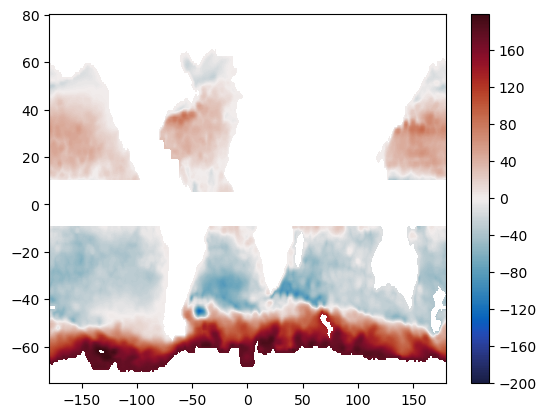

In [8]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [9]:
# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')

In [10]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_1deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_1deg.load()

CPU times: user 2.05 s, sys: 1.77 s, total: 3.82 s
Wall time: 23.9 s


<xarray.DataArray (yt_ocean: 300, xt_ocean: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77

In [11]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_level')
darray = var_search.to_dask()
darray = darray['sea_level']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_025deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_025deg.load()

CPU times: user 1.41 s, sys: 154 ms, total: 1.56 s
Wall time: 1min 11s


<xarray.DataArray (yt_ocean: 1080, xt_ocean: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

In [12]:
%%time
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

chunks={'xt_ocean': 400, 'yt_ocean': 300}

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='eta_t', frequency='1 daily')
darray = var_search.to_dask()
darray = darray['eta_t']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_level = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
    
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='sea_levelsq')
darray = var_search.to_dask()
darray = darray['sea_levelsq']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
sea_levelsq = darray.sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).mean('time')
sla_rms_01deg = (sea_levelsq - sea_level**(2.0))**(0.5)
sla_rms_01deg.load()

CPU times: user 29.3 s, sys: 1.55 s, total: 30.9 s
Wall time: 1h 31min 52s


<xarray.DataArray (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [13]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')

In [14]:
gyre_psi_1deg = get_gyre_psi('1deg')
gyre_psi_025deg = get_gyre_psi('025deg')
gyre_psi_01deg = get_gyre_psi('01deg')

In [15]:
## All data is now loaded - make a dictionary for plotting
gyre_psi_dict = {'1deg': gyre_psi_1deg, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
sla_rms_dict = {'1deg': sla_rms_1deg, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}
# gyre_psi_dict = {'1deg': gyre_psi_1deg} #, '025deg': gyre_psi_025deg, '01deg': gyre_psi_01deg}
# sla_rms_dict = {'1deg': sla_rms_1deg} #, '025deg': sla_rms_025deg, '01deg': sla_rms_01deg}

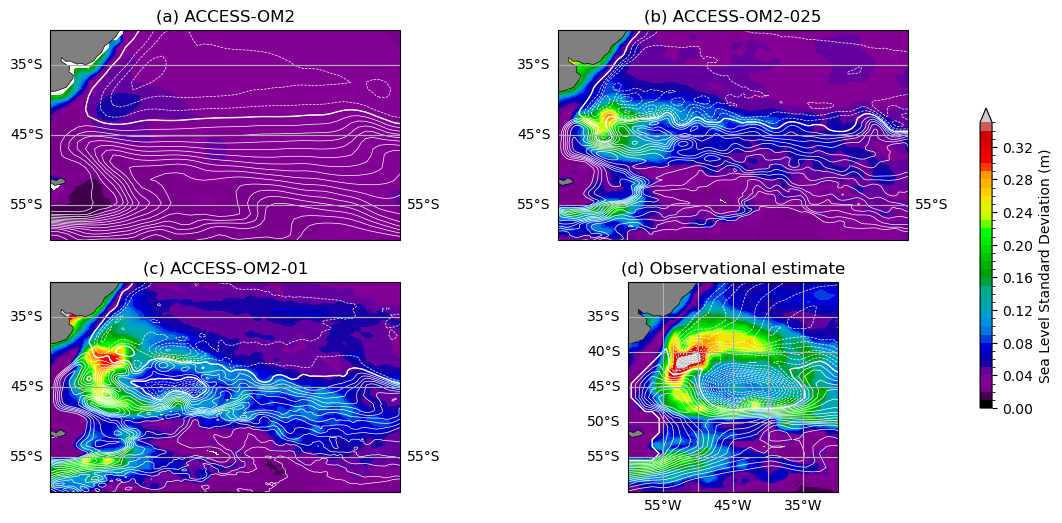

In [16]:
# Malvinas Region - TODO: fix!
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-150,150.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-60, -10, -60, -30], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160, -140],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-60, -30, -60, -30], crs=ccrs.PlateCarree())
# gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=range(-60,-29,5),ylocs=range(-60,-29,5))
gl.xlabels_top = False
# gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
# gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('malvinas_barotropic_streamfunctions')

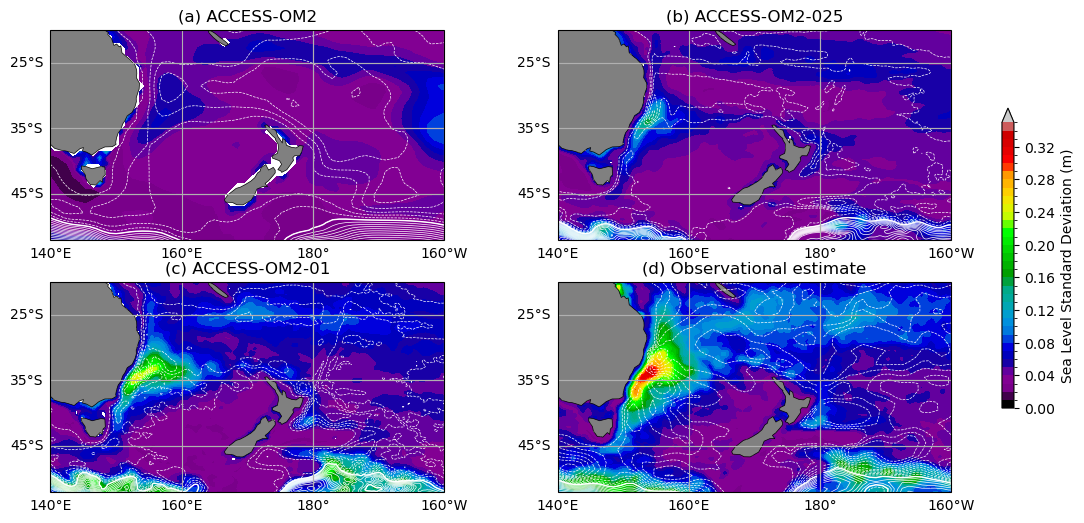

In [17]:
# EAC Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.351,0.01)
clev2 = np.arange(-50,150.01,5)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
    gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-220, -160, -52, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-220, -200, -180, -160],ylocs=[-45, -35, -25, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160],ylocs=[-45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('eac_barotropic_streamfunctions')

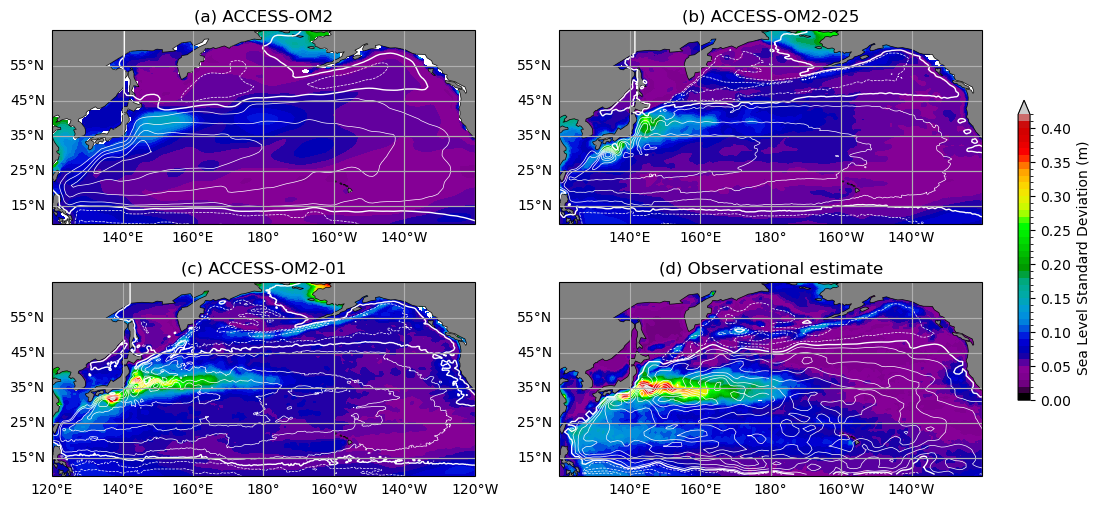

In [18]:
# Kuroshio Region
plt.figure(figsize(12,6))
clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False

p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('kuroshio_barotropic_streamfunctions')

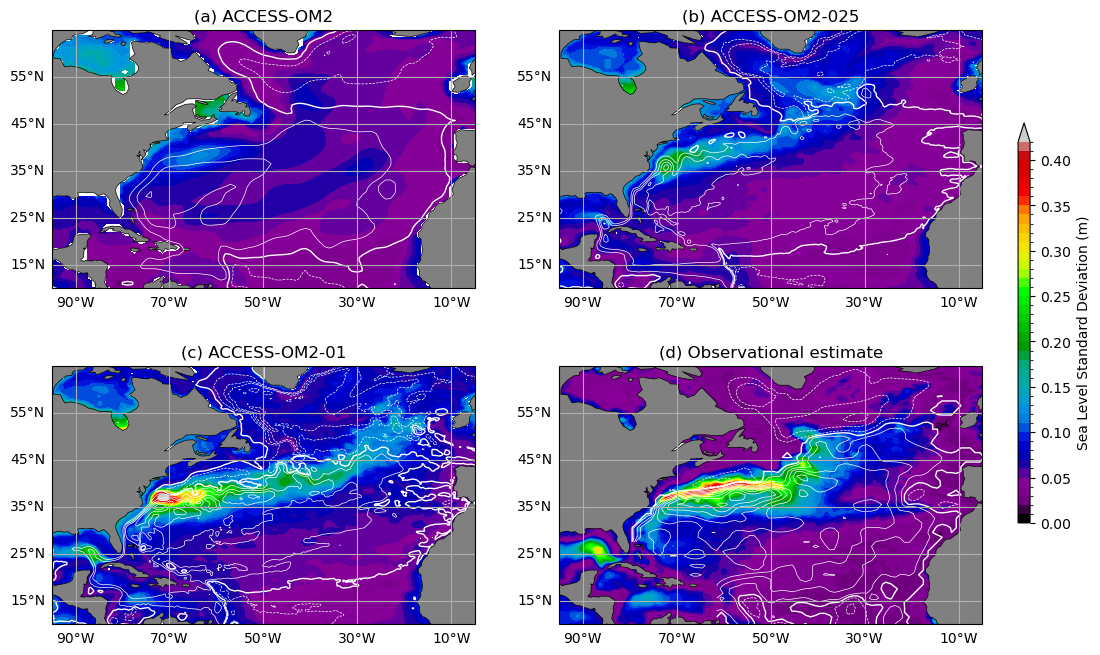

In [19]:
# Gulf Stream Region
plt.figure(figsize(12,8))
clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('gulfstream_barotropic_streamfunctions')

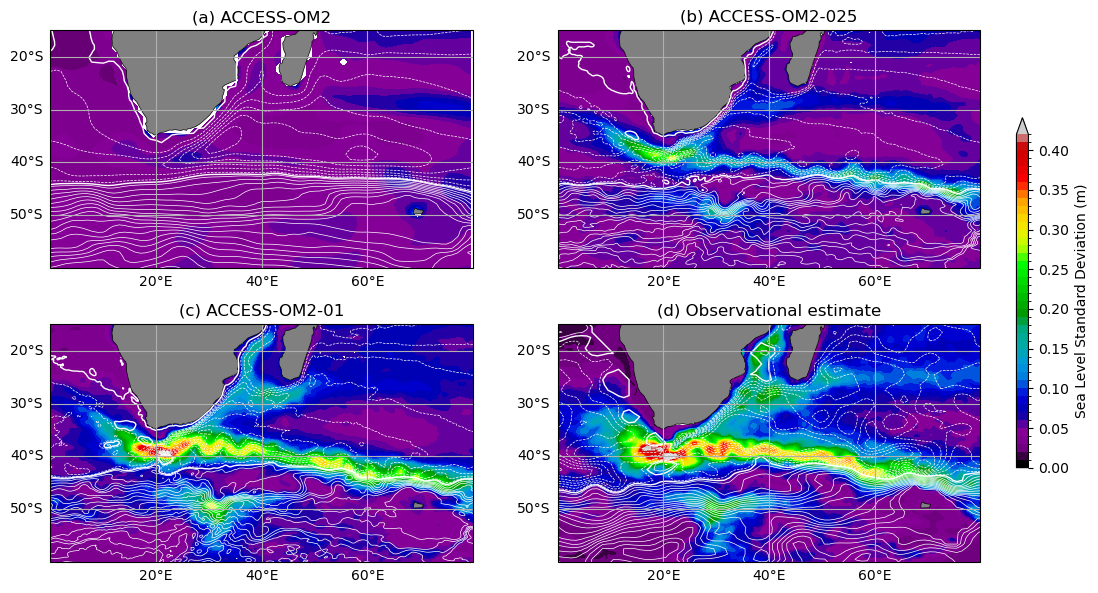

In [20]:
# Agulhas Region
    
plt.figure(figsize(12,7))
clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,200.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    sla_rms = sla_rms_dict[ekey]
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent([0, 80, -60, -15], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([0, 20, 40, 60, 80])
    gl.ylocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([0, 80, -60, -15], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([0, 20, 40, 60, 80])
gl.ylocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('(d) Observational estimate')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')

savefigure('agulhas_barotropic_streamfunctions')

1deg_jra55v13_iaf_spinup1_B1
025deg_jra55v13_iaf_gmredi6
01deg_jra55v13_iaf


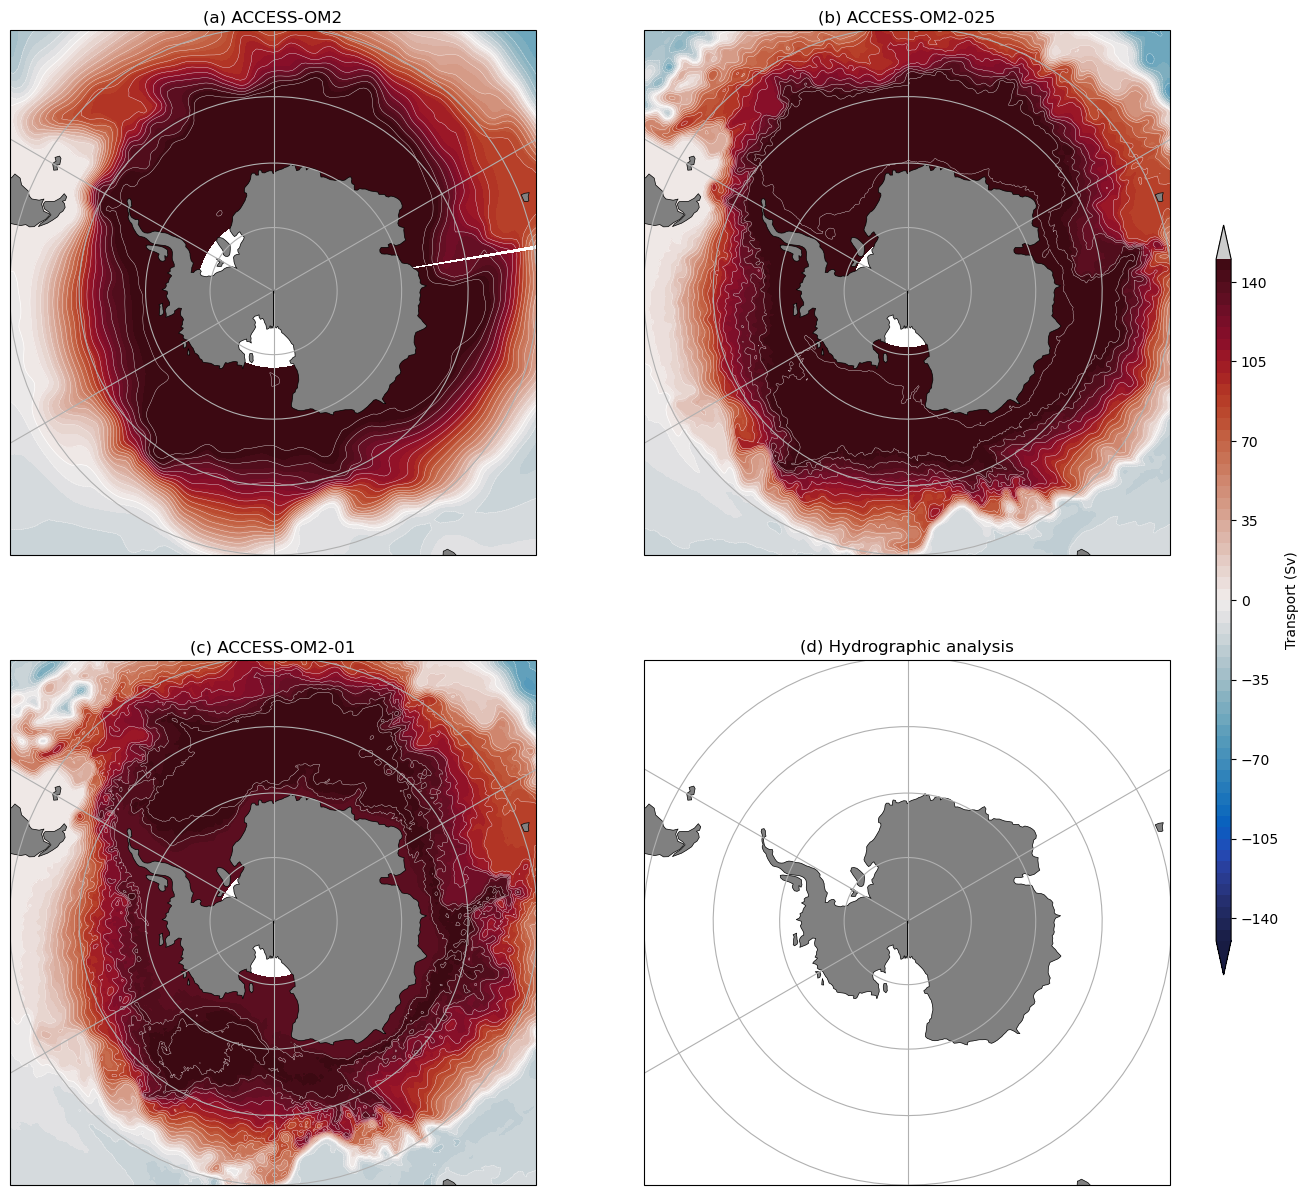

In [21]:
# Antarctic Region
plt.figure(figsize(15,15))
clev = np.arange(-150,150.01,5)
clev2 = np.arange(-155,155.01,10)

for i, ekey in enumerate(exptdata.exptdict.keys()):
    expt = exptdata.exptdict[ekey]['expt']
    print(expt)
    gyre_psi = gyre_psi_dict[ekey]
    
    ax = plt.subplot(2,2,i+1,projection=ccrs.SouthPolarStereo())
    ax.add_feature(land_50m)
    ax.set_extent([-280, 80 , -90, -50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
    gl.xlocator = mticker.FixedLocator([-240, -180, -120, -60, 0, 60])
    gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])


ax = plt.subplot(2,2,4,projection=ccrs.SouthPolarStereo())
ax.add_feature(land_50m)
ax.set_extent([-280, 80 , -90, -50], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.xlocator = mticker.FixedLocator([-240, -180, -120, -60, 0, 60])
gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.SouthPolarStereo()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('acc_barotropic_streamfunctions')

Text(0.5, 1.0, '(c) ACCESS-OM2-01')

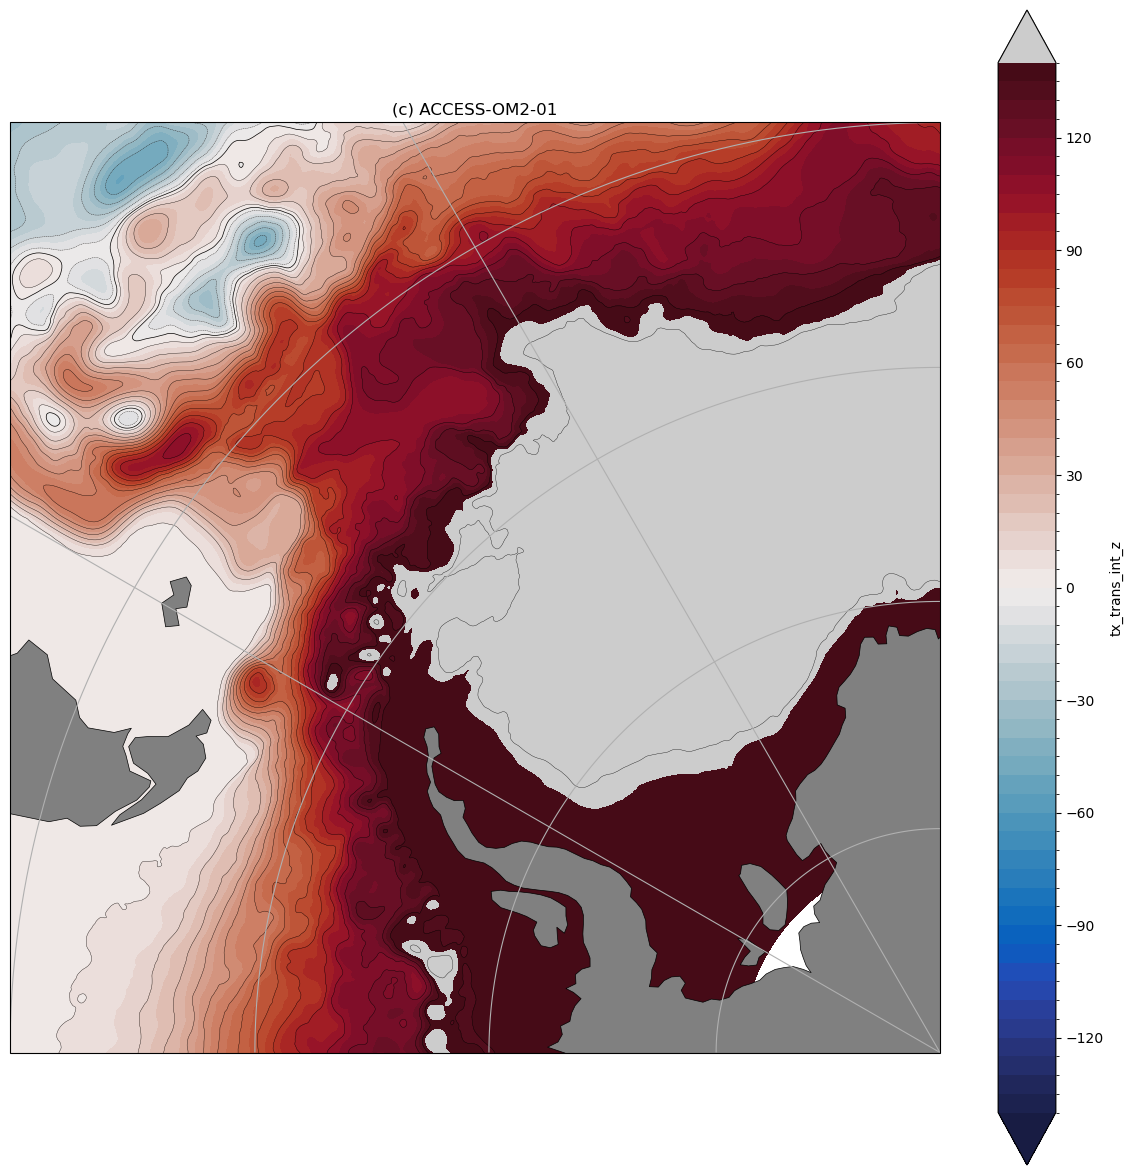

In [22]:
plt.figure(figsize(15,15))

clev = np.arange(-140,140.01,5)
clev2 = np.arange(-145,145.01,10)

expt = exptdata.exptdict['01deg']['expt']
gyre_psi = gyre_psi_dict[ekey]
    
ax = plt.subplot(1,1,1,projection=ccrs.SouthPolarStereo())
ax.add_feature(land_50m)
ax.set_extent([-90, 0 , -90, -50], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
gl.xlocator = mticker.FixedLocator([-90, -60, -30, 0])
gl.ylocator = mticker.FixedLocator([-90, -80, -70, -60, -50])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=True, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title(plot_labels[i]+exptdata.exptdict[ekey]['desc'])

# Everything below here uses old basemap methods.

In [23]:
def global_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-160,160.01,2)
    clev2 = np.arange(-140,140.01,10)
    
    map = Basemap(projection='mbtfpq',lon_0 = -100,resolution='l')
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-60.,61.,30.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(-180.,181.,90.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [24]:
def agulhas_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)
    
    map = Basemap(llcrnrlon=10,llcrnrlat=-50,urcrnrlon=79.9,urcrnrlat=-20,
             resolution='l', projection='cyl', lat_0 = 35, lon_0 = -35)
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    map.drawparallels(np.arange(-50.,-20.,10.),labels=[True,False,False,False])
    map.drawmeridians(np.arange(0.,81.,20.),labels=[False,False,False,True])
    
    X, Y = map(geolon_t,geolat_t)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [25]:
def kuroshio_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-240,urcrnrlon=-120,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [26]:
def gulfstream_map_psi(gyre_psi,geolon_t,geolat_t):
    clev = np.arange(-80,80.01,2)
    clev2 = np.arange(-70,70.01,10)

    map = Basemap(projection='cyl',llcrnrlat=10,urcrnrlat=64.9,\
            llcrnrlon=-95,urcrnrlon=-5,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

In [27]:
def eac_map_psi(gyre_psi,geolon,geolat):
    clev = np.arange(-30,30.01,1)
    clev2 = np.arange(-25,25.01,5)
    
    map = Basemap(projection='cyl',llcrnrlat=-55,urcrnrlat=-20,\
            llcrnrlon=-220,urcrnrlon=-140,resolution='l') 
    map.drawcoastlines(linewidth=0.25)
    map.fillcontinents(color='gray',lake_color='gray')
    # draw parallels and meridians.
    map.drawparallels(np.arange(-60.,81.,10.),labels=[True,False,False,False],linewidth=0.25)
    map.drawmeridians(np.arange(-160.,181.,20.),labels=[False,False,False,True],linewidth=0.25)
    
    X, Y = map(geolon_t.values,geolat_t.values)
    
    p1=map.contourf(X,Y,gyre_psi, cmap=cm.cm.balance, levels=clev, extend='both') #CMRmap_r, gist_stern_r

    map.contour(X,Y,gyre_psi,levels=clev2,colors='k',linewidths=0.25)
    map.contour(X,Y,gyre_psi,levels=[0.0,],colors='k',linewidths=0.5)
    
    return p1

## Plot gyre transport, with DP transport subtracted

This is the plot designed for the model evaluation paper.

In [32]:
%%time
plt.figure(1,figsize(8,12))
plt.figure(2,figsize(12,6))
plt.figure(3,figsize(12,6))
plt.figure(4,figsize(12,8))
plt.figure(5,figsize(12,6))

plot_labels=['(a) ','(b) ','(c) ']

#for i, ekey in enumerate(exptdata.exptdict.keys()):
for i, ekey in enumerate(['1deg']):
    print(ekey)
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey)
    print('\taaaa')
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='geolon_t')
    var_search = var_search.search(path=var_search.df['path'][0])
    darray = var_search.to_dask()
    darray = darray['geolon_t']
    print('\tbbbb')
    geolon_t = darray.mean('time')
    print('\tcccc')
    cat_subset = catalog[expt]
    var_search = cat_subset.search(variable='geolat_t')
    var_search = var_search.search(path=var_search.df['path'][0])
    darray = var_search.to_dask()
    darray = darray['geolat_t']
    print('\tdddd')
    geolat_t = darray.mean('time')
    print('\teeee')
    
    label=plot_labels[i]
    
    plt.figure(1)
    plt.subplot(3,1,i+1)
    p1 =global_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(2)
    plt.subplot(2,2,i+1)
    p2 =agulhas_map_psi(gyre_psi,geolon_t.values,geolat_t.values)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(3)
    plt.subplot(2,2,i+1)
    p3 = kuroshio_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(4)
    plt.subplot(2,2,i+1)
    p4 = gulfstream_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
    plt.figure(5)
    plt.subplot(2,2,i+1)
    p5 = eac_map_psi(gyre_psi,geolon_t,geolat_t)
    plt.title(label+exptdata.exptdict[ekey]['desc'])
    
plt.figure(1)
ax3 = plt.axes([0.92,0.35,0.02,0.3])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('global_barotropic_streamfunctions')

plt.figure(2)
subplot(224)
agulhas_map_psi(psi,lon,lat)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p2,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('agulhas_barotropic_streamfunctions')

plt.figure(3)
subplot(224)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p3,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('kuroshio_barotropic_streamfunctions')

plt.figure(4)
subplot(224)
plt.title('(d) Hydrographic analysis')
ax3 = plt.axes([0.93,0.3,0.01,0.4])
cb = plt.colorbar(p4,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('gulfstream_barotropic_streamfunctions')

plt.figure(5)
subplot(224)
plt.title('(d) .sel(time')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p5,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
savefigure('eac_barotropic_streamfunctions')

1deg
	aaaa
	bbbb


ValueError: 'time' not found in array dimensions ('yt_ocean', 'xt_ocean')

<Figure size 800x1200 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [33]:
darray

<xarray.DataArray 'geolon_t' (yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-geolon_t, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    long_name:     tracer longitude
    units:         degrees_E
    valid_range:   [-281.  361.]
    cell_methods:  time: point
    ncfiles:       ['/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spin...
    contact:       Abhishek Savita
    email:         Abhishek.Savita@csiro.au
    created:       2019-04-12
    description:   1 degree ACCESS-OM2 global model configuration under inter...
    notes:         Source code: https://github.com/COSIMA/access-om2/releases...

In [34]:
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='geolat_t')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['geolat_t']


In [35]:
darray

<xarray.DataArray 'geolat_t' (yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-geolat_t, shape=(300, 360), dtype=float32, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    long_name:     tracer latitude
    units:         degrees_N
    valid_range:   [-91.  91.]
    cell_methods:  time: point
    ncfiles:       ['/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spin...
    contact:       Abhishek Savita
    email:         Abhishek.Savita@csiro.au
    created:       2019-04-12
    description:   1 degree ACCESS-OM2 global model configuration under inter...
    notes:         Source code: https://github.com/COSIMA/access-om2/releases...